# Draw

## Boilerplate

In [1]:
import numpy  as np
from copy import copy

import random
import math
import itertools
from more_itertools import pairwise

from random import random, shuffle, uniform, randint
from io import BytesIO

import cairo
import IPython.display
import PIL
import PIL.Image
import PIL.ImageFilter

In [2]:
XMAX = 105
XMIN = -100
YMAX = 185
YMIN = -90

XMID = (XMAX + XMIN) / 2.0
YMID = (YMAX + YMIN) / 2.0

PEN_DELAY = 125

START_X = 0
START_Y = -200

In [3]:
def clamp(value, min_value, max_value):
    return min(max(value, min_value), max_value)

In [4]:
class GCODE:
    def __init__(self, name="foobar", feedrate=1000):
        self.start_pos = np.array([START_X, START_Y])
        self.pos = copy(self.start_pos)
        self.f = open(f"{name}.gcode", "wt")
        self.feedrate = feedrate
        
        self.servo = "P0"
        self.pen_up_pos = "S0"
        self.pen_down_pos = "S90"
         
        self.f.write("M17\n")  # Ensure steppers are enabled
        self.f.write("M121\n")  # Disable endstops, just in case
        self.f.write("G90\n")  # Set absolute positioning
        self.f.write("; potatolangelo\n")
        self.pen_up()
        self.move_to_starting_position()
        
    def pen_up(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_up_pos} T{PEN_DELAY}\n")
    
    def pen_down(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_down_pos} T{PEN_DELAY}\n")
        
    def finish_moves(self):
        self.f.write("M400\n")
        
    def move_to(self, x, y, feedrate=None):
        feedrate = feedrate or self.feedrate
        
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def move_to_mid_point(self, feedrate=None):
        self.move_to(XMID, YMID, feedrate=feedrate)
        
    def move_to_starting_position(self, feedrate=None):
        self.move_to(self.start_pos[0], self.start_pos[1], feedrate=feedrate)
        
    def step(self, dx, dy, feedrate=None):
        feedrate = feedrate or self.feedrate
        self.pos[0] += dx
        self.pos[1] += dy
        
        x = self.pos[0]
        y = self.pos[1]
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def square_filled(self, xmin, ymin, xmax, ymax, dy=1, zigzag=True):
        print(f"square filled centered on {(xmin + xmax) / 2.0:.2f} {(ymin + ymax) / 2.0:.2f}")
        
        self.pen_up()    
        self.move_to((xmin + xmax) / 2.0, (ymin + ymax) / 2.0)
        
        self.square(xmin, ymin, xmax, ymax)
        
        self.pen_up()    
        self.move_to(xmin, ymin)
        self.pen_down()
        
        x = xmin
        y = ymin
        while y < ymax:
            y += dy
            
            # When zigzag is true the pen moves in a saw tooth pattern,
            # otherwise it goes in a square wave form.
            # Zigzag looks good with ballpoint pens, while the square pattern
            # works best on thicker points.
            if not zigzag:
                self.move_to(x, y)
            
            if x == xmin:
                x = xmax
            else:
                x = xmin
                
            self.move_to(x, y)
            
        self.pen_up()
                
    def square(self, xmin, ymin, xmax, ymax):
        self.move_to(xmin, ymin)
        self.pen_down()
        self.move_to(xmax, ymin)
        self.move_to(xmax, ymax)
        self.move_to(xmin, ymax)
        self.move_to(xmin, ymin)
        self.pen_up()
            
    def flush(self):
        self.f.flush()

# The actual algo

In [5]:
def plot(data, lines=True):
    svgio = BytesIO()

    with cairo.SVGSurface(svgio, width, height) as surface:
        context = cairo.Context(surface)
        context.scale(width, height)
        context.set_line_width(0.001)
        context.set_source_rgba(0, 0, 0, 1)
        context.set_line_cap(cairo.LINE_CAP_ROUND)
        
        if not lines:
            for x, y in data:
                context.move_to(x / width, y / height)
                context.line_to(x / width, y / height)
                context.stroke()
        else:
            context.move_to(data[0][0] / width, data[0][1] / height)
    
            for x, y in data:
                context.line_to(x / width, y / height)

            context.stroke()

    return IPython.display.SVG(data=svgio.getvalue())

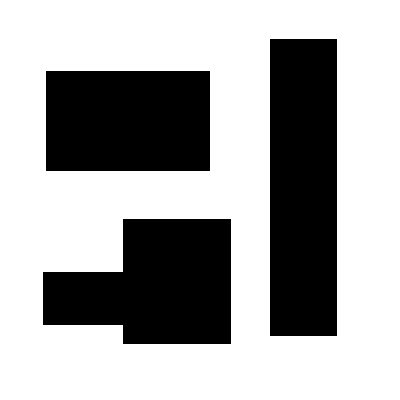

In [6]:
image_name = "squares.jpg"
# image_name = "full-moon-with-face.png"

IPython.display.Image(filename=image_name) 

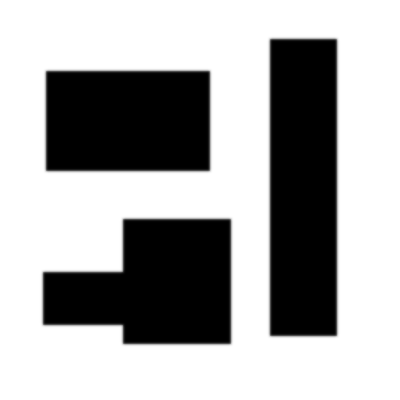

In [7]:
original_image = PIL.Image.open(image_name)
image = copy(original_image)

# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.CONTOUR)

# image = image.filter(PIL.ImageFilter.DETAIL)

# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)

# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)

# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
IPython.display.display(image)

In [8]:
image_pixels = image.convert("RGB")

In [9]:
points = []

width = original_image.width
height = original_image.height

for y in range(height):
    for x in range(width):
        r, g, b = image_pixels.getpixel((x, y))
        intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
        
        if random() < intensity * 0.15:
            points.append(np.array((x, y)))
            
len(points)

8141

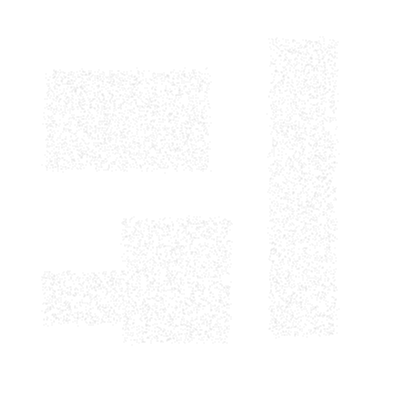

In [10]:
plot(points, lines=False)

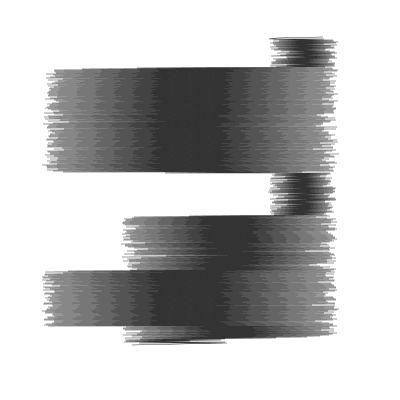

In [11]:
plot(points)

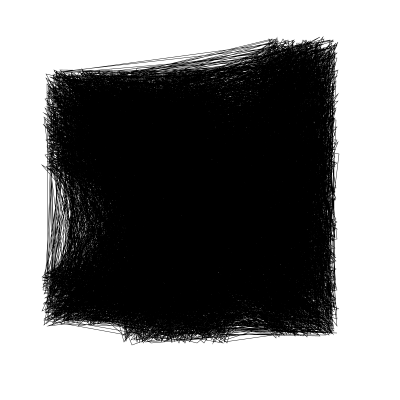

In [12]:
shuffle(points)
plot(points)

In [13]:
def nearest_first(points):
    _points = copy(points)
    new_points = []
    p = points.pop()
    
    new_points.append(p)
    
    while len(_points) > 0:
        dist = float("inf")
        nearest_i = 0
        
        shuffle(_points)
        
        for i in range(int(len(_points) / 2)):
#         for i in range(int(len(_points))):
            new_dist = np.linalg.norm(p - _points[i])
            
            if  new_dist < dist:
                dist = new_dist
                nearest_i = i
                
    
        if len(_points) % 250 == 0:
            print(f"{len(_points)}")
            
        p = _points.pop(nearest_i)
        new_points.append(p)
    
    return new_points

8000
7750
7500
7250
7000
6750
6500
6250
6000
5750
5500
5250
5000
4750
4500
4250
4000
3750
3500
3250
3000
2750
2500
2250
2000
1750
1500
1250
1000
750
500
250


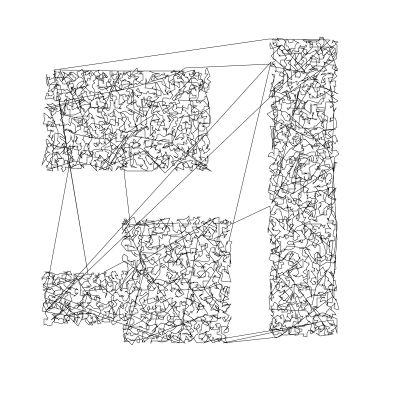

In [14]:
new_points = nearest_first(points)
plot(new_points)

Scale the dataset

In [18]:
def scale(data):
    xmin = min([x[0] for x in data])
    xmax = max([x[0] for x in data])
    ymin = min([x[1] for x in data])
    ymax = max([x[1] for x in data])
        
    return [
        (
            round(((x - xmin) / (xmax - xmin)) * (XMAX - XMIN) + XMIN, 2),
            round(((y - ymin) / (ymax - ymin)) * (YMAX - YMIN) + YMIN, 2),
        )
        for x, y in data
    ]

scaled_points = scale(new_points)

Generate the gcode

In [19]:
filename = "test"

gcode = GCODE(filename, feedrate=1000)
gcode.move_to_starting_position()

gcode.pen_down()

for x, y in scaled_points:
    gcode.move_to(x, y)

gcode.pen_up()

gcode.move_to_starting_position()
gcode.flush()

# Preview

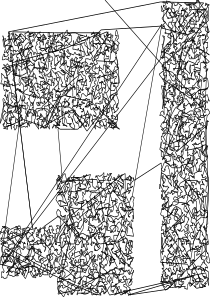

In [20]:
svgio = BytesIO()
filename = f"{filename}.gcode"

last_x = (START_X - XMIN) / (XMAX - XMIN)
last_y = (START_Y - YMIN) / (YMAX - YMIN)

width = 210
height = 297

drawing = False

with cairo.SVGSurface(svgio, width, height) as surface, open(filename) as f:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.0025)
    context.set_source_rgba(0, 0, 0, 1)
    
    for line in f.readlines():
        if "G0" in line:
                
            tokens = line.strip().split(" ")[1:]
            x = (float(tokens[0][1:]) - XMIN) / (XMAX - XMIN)
            y = (float(tokens[1][1:]) - YMIN) / (YMAX - YMIN)

            if writing:  
                context.move_to(last_x, last_y)
                context.line_to(x, y)
                context.stroke()

            last_x = x
            last_y = y
            
        if "M280 P0" in line:
            tokens = line.strip().split(" ")[1:]
            if tokens[1] == "S0":
                writing = False
            elif tokens[1] == "S90":
                writing = True

IPython.display.SVG(data=svgio.getvalue())